<a href="https://colab.research.google.com/github/Linar23/Kaggle/blob/master/RSNA_STR_Pulmonary_Embolism_Detection_%5BTraining%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download data from Kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [ ]:
# Download batches from Kaggle
%%shell
num_files=5
for (( num=0; num <= num_files-1; num++ )) do 
    kaggle datasets download -d teeyee314/pe-train-512x512-fold-0-batch-$num; 
done

100% 3.91G/3.91G [01:20<00:00, 77.5MB/s]
100% 3.91G/3.91G [01:20<00:00, 51.9MB/s]
100% 4.05G/4.06G [01:52<00:00, 37.2MB/s]
100% 4.06G/4.06G [01:52<00:00, 38.8MB/s]
100% 4.06G/4.07G [01:41<00:00, 103MB/s] 
100% 4.07G/4.07G [01:41<00:00, 43.0MB/s]
100% 4.02G/4.03G [01:52<00:00, 24.2MB/s]
100% 4.03G/4.03G [01:52<00:00, 38.4MB/s]
100% 4.13G/4.13G [01:41<00:00, 32.5MB/s]
100% 4.13G/4.13G [01:41<00:00, 43.8MB/s]


In [ ]:
!mkdir data

In [ ]:
import zipfile
import os


num_files = 5

# Unzip data and remove zip files
zipfile_name = "pe-train-512x512-fold-0-batch-{}.zip"

for i in range(num_files):
  with zipfile.ZipFile(zipfile_name.format(i),"r") as zip_ref:
      zip_ref.extractall("data")
      os.remove(zipfile_name.format(i))

In [ ]:
#!rm -rf data

In [ ]:
!kaggle competitions download -c rsna-str-pulmonary-embolism-detection -f train.csv
!kaggle competitions download -c rsna-str-pulmonary-embolism-detection -f test.csv

!unzip train.csv.zip
!unzip test.csv.zip

!rm train.csv.zip
!rm test.csv.zip

 57% 9.00M/15.7M [00:01<00:00, 7.74MB/s]
100% 15.7M/15.7M [00:01<00:00, 14.2MB/s]
  0% 0.00/1.23M [00:00<?, ?B/s]
100% 1.23M/1.23M [00:00<00:00, 80.7MB/s]
Archive:  train.csv.zip
  inflating: train.csv               
Archive:  test.csv.zip
  inflating: test.csv                


## EDA

In [ ]:
import pandas as pd


train_df = pd.read_csv('train.csv')
train_df.head()

,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,pe_present_on_image,negative_exam_for_pe,qa_motion,qa_contrast,flow_artifact,rv_lv_ratio_gte_1,rv_lv_ratio_lt_1,leftsided_pe,chronic_pe,true_filling_defect_not_pe,rightsided_pe,acute_and_chronic_pe,central_pe,indeterminate
0,6897fa9de148,2bfbb7fd2e8b,c0f3cb036d06,0,0,0,0,0,0,1,1,0,0,1,0,0,0
1,6897fa9de148,2bfbb7fd2e8b,f57ffd3883b6,0,0,0,0,0,0,1,1,0,0,1,0,0,0
2,6897fa9de148,2bfbb7fd2e8b,41220fda34a3,0,0,0,0,0,0,1,1,0,0,1,0,0,0
3,6897fa9de148,2bfbb7fd2e8b,13b685b4b14f,0,0,0,0,0,0,1,1,0,0,1,0,0,0
4,6897fa9de148,2bfbb7fd2e8b,be0b7524ffb4,0,0,0,0,0,0,1,1,0,0,1,0,0,0


In [ ]:
test_df = pd.read_csv('test.csv')
test_df.head()

,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID
0,df06fad17bc3,857e3d760445,c3163725fcf6
1,df06fad17bc3,857e3d760445,d54a8daaf836
2,df06fad17bc3,857e3d760445,bdc531b699cd
3,df06fad17bc3,857e3d760445,9e6a68e27df0
4,df06fad17bc3,857e3d760445,25e3307ba7da


data/de9f11defd64.jpg


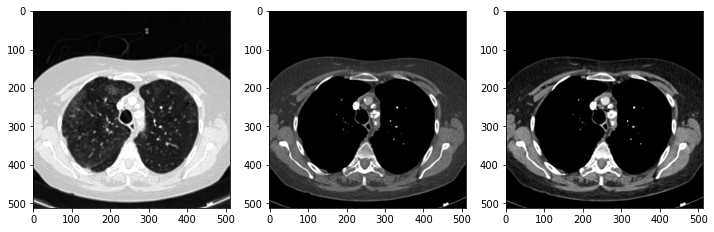

In [ ]:
import cv2
from matplotlib import pyplot as plt


row = train_df.iloc[200]
print(f"data/{row[2]}.jpg")
img = cv2.imread(f"data/{row[2]}.jpg")
plt.figure(figsize=[12, 6])
plt.subplot(131)
plt.imshow(img[:,:,0], cmap='gray')
plt.subplot(132)
plt.imshow(img[:,:,1], cmap='gray')
plt.subplot(133)
plt.imshow(img[:,:,2], cmap='gray')

## Install libraries

In [ ]:
!pip3 uninstall albumentations
!pip3 install albumentations==0.4.6

Uninstalling albumentations-0.1.12:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/albumentations-0.1.12.dist-info/*
    /usr/local/lib/python3.6/dist-packages/albumentations/*
Proceed (y/n)? y
  Successfully uninstalled albumentations-0.1.12
     |████████████████████████████████| 122kB 5.9MB/s 
     |████████████████████████████████| 952kB 6.9MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp36-none-any.whl size=65165 sha256=014c6b1d9316b4949d54a370b11eefbc2db582aec8fae99407fd1aa455926003
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


## Training

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import cv2
import os
from matplotlib import pyplot as plt
import os
import cv2
import numpy as np
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader,Dataset
import albumentations as albu
from skimage.color import gray2rgb
import functools
import torch
from tqdm.auto import tqdm

In [ ]:
# Read input csv files

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [ ]:
# Filter existing pics from csv

SOPInstanceUID_list = [el[:-4] for el in os.listdir("data")]
train_df = train_df[train_df['SOPInstanceUID'].isin(SOPInstanceUID_list)]

In [ ]:
SOPInstanceUID_list = [el[:-4] for el in os.listdir("data")]
test_df[test_df['SOPInstanceUID'].isin(SOPInstanceUID_list)]

,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID


In [ ]:
def get_training_augmentation(y=256,x=256):
    train_transform = [albu.RandomBrightnessContrast(p=0.3),
                           albu.VerticalFlip(p=0.5),
                           albu.HorizontalFlip(p=0.5),
                           albu.Downscale(p=1.0,scale_min=0.35,scale_max=0.75,),
                           albu.Resize(y, x)]
    return albu.Compose(train_transform)


formatted_settings = {
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],}


def preprocess_input(
    x, mean=None, std=None, input_space="RGB", input_range=None, **kwargs
):

    if input_space == "BGR":
        x = x[..., ::-1].copy()

    if input_range is not None:
        if x.max() > 1 and input_range[1] == 1:
            x = x / 255.0

    if mean is not None:
        mean = np.array(mean)
        x = x - mean

    if std is not None:
        std = np.array(std)
        x = x / std

    return x

def get_preprocessing(preprocessing_fn):
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

def get_validation_augmentation(y=256,x=256):
    """Add paddings to make image shape divisible by 32"""
    test_transform = [albu.Resize(y, x)]
    return albu.Compose(test_transform)

def to_tensor(x, **kwargs):
    """
    Convert image or mask.
    """
    return x.transpose(2, 0, 1).astype('float32')

class CTDataset2D(Dataset):
    def __init__(self,df,transforms = albu.Compose([albu.HorizontalFlip()]),preprocessing=None,size=256,mode='val'):
        self.df_main = df.values
        if mode=='val':
            self.df = self.df_main
        else:
            self.update_train_df()
            
        self.transforms = transforms
        self.preprocessing = preprocessing
        self.size=size


    def __getitem__(self, idx):
        row = self.df[idx]
        img = cv2.imread(f"data/{row[2]}.jpg")
        label = row[3:].astype(int)
        label[2:] = label[2:] if label[0]==1 else 0
        if self.transforms:
            img = self.transforms(image=img)['image']
        if self.preprocessing:
            img = self.preprocessing(image=img)['image']
        return img, torch.from_numpy(label.reshape(-1))

    def __len__(self):
        return len(self.df)
    
    def update_train_df(self):
        df0 = self.df_main[self.df_main[:,3]==0]
        df1 = self.df_main[self.df_main[:,3]==1]
        np.random.shuffle(df0)
        self.df = np.concatenate([df0[:len(df1)],df1],axis=0)
        

def norm(img):
    img-=img.min()
    return img/img.max()

In [ ]:
StudyInstanceUID = list(set(train_df['StudyInstanceUID']))
print(len(StudyInstanceUID))
t_df = train_df[train_df['StudyInstanceUID'].isin(StudyInstanceUID[0:6500])]
v_df = train_df[train_df['StudyInstanceUID'].isin(StudyInstanceUID[6500:])]

1010


In [ ]:
class config:
  model_name = "resnet18"
  batch_size = 128
  WORKERS = 4
  classes = 14
  resume = False
  epochs = 10
  MODEL_PATH = 'log/cpt'
  if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)

In [ ]:
preprocessing_fn = functools.partial(preprocess_input, **formatted_settings)
train_dataset = CTDataset2D(t_df,
                            transforms=get_training_augmentation(),
                            preprocessing=get_preprocessing(preprocessing_fn),mode='train')
val_dataset = CTDataset2D(v_df,
                            transforms=get_validation_augmentation(),
                            preprocessing=get_preprocessing(preprocessing_fn))

In [ ]:
train = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=config.WORKERS, pin_memory=True)
val = DataLoader(val_dataset, batch_size=config.batch_size*2, shuffle=False, num_workers=config.WORKERS, pin_memory=True)

In [ ]:
x,y = train_dataset[-400]
x.shape, len(y), y, len(train_dataset)

((3, 256, 256), 14, tensor([1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0]), 23248)

In [ ]:
import torchvision.models as models


model = models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(in_features=512, out_features=config.classes, bias=True)
model = model.cuda()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
optimizer = torch.optim.Adam(model.parameters(),lr=5e-4,weight_decay=0.00001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=300,eta_min=0.000001)
loss_fn = torch.nn.BCEWithLogitsLoss()

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau


class TrainerClass:
    def __init__(self, loss_fn, model, optimizer, scheduler):
        self.loss_fn = loss_fn
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler

        
    def batch_train(self, batch_imgs, batch_labels, batch_idx):
        batch_imgs, batch_labels = batch_imgs.cuda().float(), batch_labels.cuda().float()
        predicted = self.model(batch_imgs)
        loss = self.loss_fn(predicted.float(), batch_labels)
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()

        return loss.item(), predicted
    

    def batch_valid(self, batch_imgs,get_fet):
        self.model.eval()
        batch_imgs = batch_imgs.cuda()
        with torch.no_grad():
            predicted = self.model(batch_imgs)
        predicted = torch.sigmoid(predicted)

        return predicted
    

    def train_epoch(self, loader):
        self.model.train()
        tqdm_loader = tqdm(loader)
        current_loss_mean = 0
        for batch_idx, (imgs,labels) in enumerate(tqdm_loader):
            loss, predicted = self.batch_train(imgs, labels, batch_idx)
            current_loss_mean = (current_loss_mean * batch_idx + loss) / (batch_idx + 1)
            tqdm_loader.set_description('loss: {:.4} lr:{:.6}'.format(
                    current_loss_mean, self.optimizer.param_groups[0]['lr']))
            self.scheduler.step(batch_idx)

        return current_loss_mean
    

    def valid_epoch(self, loader,name="valid"):
        self.model.eval()
        tqdm_loader = tqdm(loader)
        current_loss_mean = 0
        for batch_idx, (imgs,labels) in enumerate(tqdm_loader):
            with torch.no_grad():
                batch_imgs = imgs.cuda().float()
                batch_labels = labels.cuda()
                predicted = self.model(batch_imgs)
                loss = self.loss_fn(predicted.float(),batch_labels.float()).item()
                current_loss_mean = (current_loss_mean * batch_idx + loss) / (batch_idx + 1)
        score = 1-current_loss_mean
        print('metric {}'.format(score))

        return score
    

    def run(self,train_loder,val_loder):
        best_score = -100000
        for e in range(config.epochs):
            print("----------Epoch {}-----------".format(e))
            current_loss_mean = self.train_epoch(train_loder)
            train_loder.dataset.update_train_df()
            score = self.valid_epoch(val_loder)
            if best_score < score:
                best_score = score
                torch.save(self.model.state_dict(),config.MODEL_PATH+"/{}_best.pth".format(config.model_name))


    def batch_valid_tta(self, batch_imgs):
        batch_imgs = batch_imgs.cuda()
        predicted = model(batch_imgs)
        tta_flip = [[-1],[-2]]
        for axis in tta_flip:
            predicted += torch.flip(model(torch.flip(batch_imgs, axis)), axis)
        predicted = predicted/(1+len(tta_flip))
        predicted = torch.sigmoid(predicted)

        return predicted.cpu().numpy()
            

    def load_best_model(self):
        if os.path.exists(config.MODEL_PATH+"/{}_best.pth".format(config.model_name)):
            self.model.load_state_dict(torch.load(config.MODEL_PATH+"/{}_best.pth".format(config.model_name)))
        

    def predict(self,imgs_tensor,get_fet = False):
        self.model.train()
        with torch.no_grad():
            return self.batch_valid(imgs_tensor,get_fet=get_fet)

In [ ]:
Trainer = TrainerClass(loss_fn, model, optimizer, scheduler)

In [ ]:
Trainer.run(train,val)

----------Epoch 0-----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



metric 1
----------Epoch 1-----------



metric 1
----------Epoch 2-----------



metric 1
----------Epoch 3-----------



metric 1
----------Epoch 4-----------



metric 1
----------Epoch 5-----------



metric 1
----------Epoch 6-----------



metric 1
----------Epoch 7-----------



metric 1
----------Epoch 8-----------



metric 1
----------Epoch 9-----------



metric 1
